In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [ ]:
#Constants

#In the deprel column
#Dependency relation types in Finnish UD
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

#In the feats column
#Cases in Finnihs UD
CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']
#Verb forms in Finnish UD
VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']
#Verb tenses in Finnish UD
VERBTENSES = ['Tense=Pres', 'Tense=Past']
#Verb voices in Finnish UD
VERBVOICES = ['Voice=Act', 'Voice=Pass']
#Verb moods in Finnish UD
VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']
#Verb 'person' in Finnish UD (aka first person, second person and so on)
PERSONS = ['Person=0', 'Person=1', 'Person=2', 'Person=3']
#Verb 'number' in Finnish UD (aka first singluar person [me] or first plural person [we] and so on)
NUMBERS = ['Number=Sing', 'Number=Plur']
#Connegative (aka verb that has been given a negative meaning by 'ei')
CONNEGATIVE = ['Connegative=Yes']
#Degrees in Finnish UD (positive, comparative, and superlative)
DEGREES = ['Degree=Pos','Degree=Cmp','Degree=Sup']
FEATS = CASES + VERBFORMS + VERBTENSES + VERBVOICES + VERBMOODS + PERSONS + NUMBERS + CONNEGATIVE + DEGREES
#In the upos column
#POS tags in Finnish UD
POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ']


ALL_FEATS = DEPRELS + FEATS + POS 

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

In [4]:
#Define sub-corpora

ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [13,14,15]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['1','2','3','4'],[sub_corp_1, sub_corp_2, sub_corp_3]))

In [5]:
effect_sizes = {}
with tqdm(range(9), desc="Iterating over subcorpora...") as pbar:
    for key1 in sub_corps:
        sub_corpus_1 = sub_corps[key1]
        for key2 in sub_corps:
            sub_corpus_2 = sub_corps[key2]
            new_key = str(key1)+"+"+str(key2)
            effect_sizes_temp = []
            for deprel in DEPRELS:
                effect_sizes_temp.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corpus_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_corpus_2, deprel, True)) )
            for ctg in [CASES, VERBFORMS, VERBMOODS, VERBTENSES, VERBVOICES, PERSONS, NUMBERS, CONNEGATIVE, DEGREES]:
                for feat in ctg:
                    effect_sizes_temp.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corpus_1, feat, True), bdf.getFeatsFeaturePerBook(sub_corpus_2, feat, True)) )
            for pos in POS:
                effect_sizes_temp.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corpus_1, pos, True), bdf.getPosFeaturePerBook(sub_corpus_2, pos, True)) )
            effect_sizes[new_key] = effect_sizes_temp
            pbar.update(1)

Iterating over subcorpora...: 100%|██████████| 9/9 [09:05<00:00, 60.64s/it]


<Axes: >

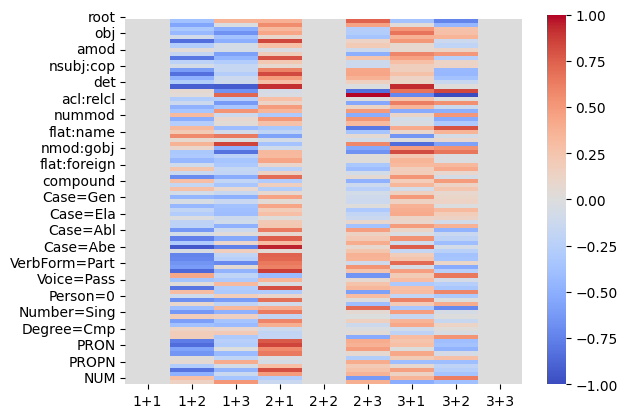

In [6]:
ef_df = pd.DataFrame(effect_sizes, index=ALL_FEATS)

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

sns.heatmap(ef_df, cmap='coolwarm', vmin=-1, vmax=1)

In [7]:
import numpy as np
import math


non_important = {}
for feat in ALL_FEATS:
    y = ef_df.loc[feat].values
    non_important[feat] = np.count_nonzero(abs(y) > 0.79)

In [8]:
from pprint import pprint
pprint(non_important)

{'ADJ': 0,
 'ADP': 0,
 'ADV': 0,
 'AUX': 0,
 'CCONJ': 0,
 'Case=Abe': 2,
 'Case=Abl': 0,
 'Case=Acc': 0,
 'Case=Ade': 0,
 'Case=All': 0,
 'Case=Com': 0,
 'Case=Ela': 0,
 'Case=Ess': 0,
 'Case=Gen': 0,
 'Case=Ill': 0,
 'Case=Ine': 0,
 'Case=Ins': 0,
 'Case=Nom': 0,
 'Case=Par': 0,
 'Case=Tra': 0,
 'Connegative=Yes': 0,
 'Degree=Cmp': 0,
 'Degree=Pos': 0,
 'Degree=Sup': 0,
 'INTJ': 0,
 'Mood=Cnd': 2,
 'Mood=Imp': 0,
 'Mood=Ind': 0,
 'NOUN': 0,
 'NUM': 0,
 'Number=Plur': 0,
 'Number=Sing': 0,
 'PRON': 2,
 'PROPN': 0,
 'Person=0': 0,
 'Person=1': 0,
 'Person=2': 0,
 'Person=3': 0,
 'SCONJ': 2,
 'Tense=Past': 2,
 'Tense=Pres': 0,
 'VERB': 0,
 'VerbForm=Fin': 0,
 'VerbForm=Inf': 0,
 'VerbForm=Part': 0,
 'Voice=Act': 0,
 'Voice=Pass': 0,
 'acl': 0,
 'acl:relcl': 0,
 'advcl': 0,
 'advmod': 0,
 'amod': 0,
 'appos': 2,
 'aux': 2,
 'aux:pass': 0,
 'case': 0,
 'cc': 0,
 'cc:preconj': 0,
 'ccomp': 4,
 'compound': 0,
 'compound:nn': 0,
 'compound:prt': 0,
 'conj': 0,
 'cop': 0,
 'cop:own': 0,
 'csub

In [9]:
meaningful_ef_size = 0.79

In [10]:
sep_between_two = []
for feat in ALL_FEATS:
    for corp1 in [1,2,3]:
        for corp2 in [0,1,2]:
            temp_df = ef_df[sub_columns(ef_df.columns, str(corp1))]
            y_1 = temp_df[temp_df.columns[corp2:min(corp2+1,2)]].loc[feat].to_numpy(na_value=0.0)
            if ((abs(y_1)>meaningful_ef_size).sum() > 0):
                sep_between_two.append(feat)

In [11]:
sep_between_rest = []
for feat in ALL_FEATS:
    for corp1 in [0,1,2]:
            temp_df = ef_df[sub_columns(ef_df.columns, str(corp1+1))]
            temp_list = [0,1,2]
            temp_list.remove(corp1)
            ts = []
            for t in temp_list:
                ts.append(np.nan_to_num(temp_df[temp_df.columns[t]].loc[feat], nan=0.0))
            if ((abs(np.array(ts))>meaningful_ef_size).sum() > 1):
                sep_between_rest.append(feat)

In [47]:
between_2_3 = []
for feat in ALL_FEATS:
    temp_df = ef_df[sub_columns(ef_df.columns, '2')]
    y_1 = temp_df[temp_df.columns[2:]].loc[feat].to_numpy(na_value=0.0)
    if ((abs(y_1)>meaningful_ef_size-0.2).sum() > 0):
        between_2_3.append(feat)

In [48]:
print(between_2_3)

['nsubj', 'nmod', 'parataxis', 'appos', 'nmod:gsubj', 'Voice=Act', 'Person=3', 'NUM']


In [12]:
dupes_removed = list(set(sep_between_two+sep_between_rest))

In [28]:
testing_df = ef_df.copy()
print(len(testing_df))
remove = [key for key in non_important if non_important[key] < 20]
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
most_important = dupes_removed
#most_important = ['vocative']
to_drop = [x for x in ALL_FEATS if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop)
print(len(testing_df_edited))

90
['nmod', 'Mood=Cnd', 'parataxis', 'Case=Abe', 'ccomp', 'aux', 'mark', 'SCONJ', 'xcomp', 'vocative', 'nmod:gsubj', 'Tense=Past', 'PRON', 'appos']
14


<Axes: >

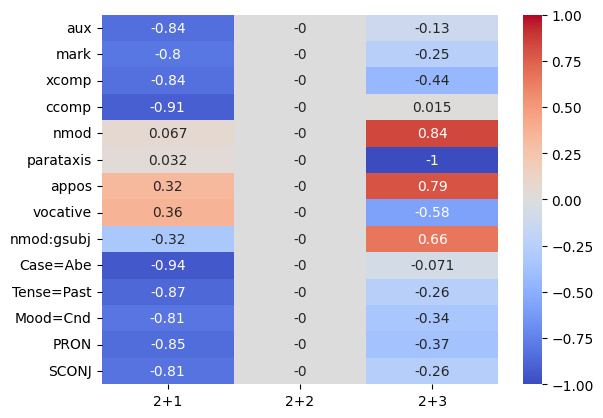

In [44]:
sns.heatmap(testing_df_edited[sub_columns(ef_df.columns, '2')]*-1, cmap='coolwarm', vmin=-1, vmax=1, annot=True)

In [30]:
windows = ['1','2','3']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [31]:
temp_1_df = testing_df_edited.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [33]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

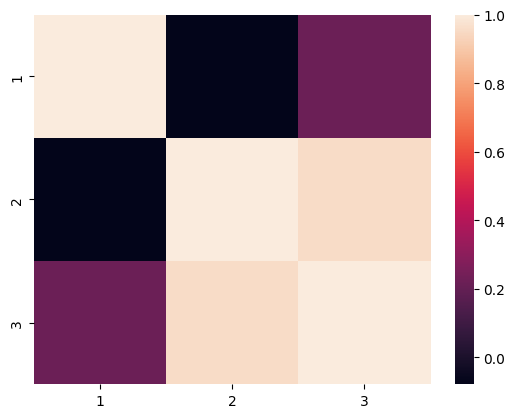

In [34]:
sns.heatmap(matrix_df_2)